In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

Station = Base.classes.station
Measurement = Base.classes.measurement

# reflect the tables
session = Session(engine)

In [7]:
# View all of the classes that automap found
all_classes = Base.classes

for class_name in all_classes.keys():
    print(class_name)

measurement
station


In [8]:
# Save references to each table
tables = {}
for table_name, table_class in Base.classes.items():
    tables[table_name] = table_class

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


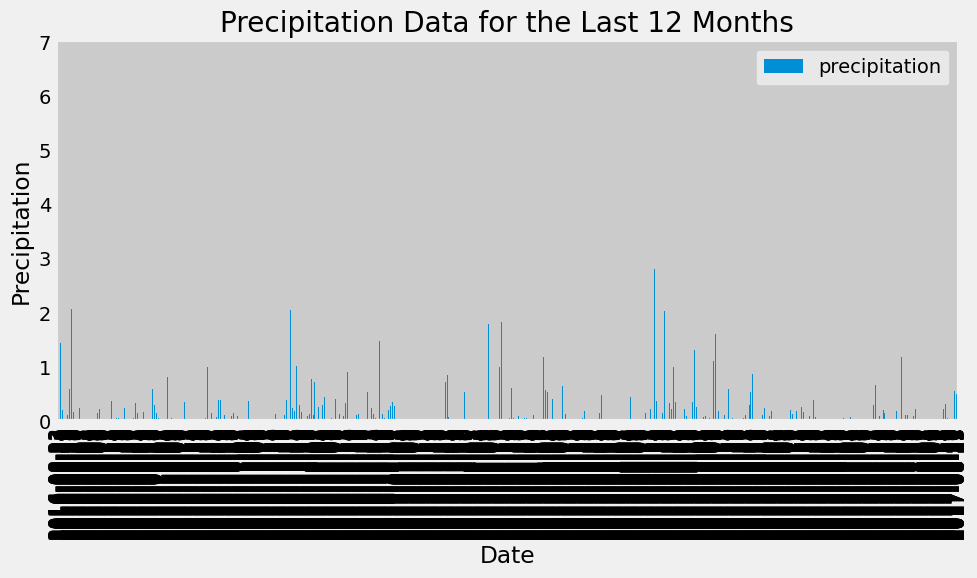

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

last_12_months_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - relativedelta(months=12)

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months_date).all()

# Calculate the date one year from the last date in data set.

most_recent_date = session.query(func.max(Measurement.date)).scalar()

last_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
one_year_ago = last_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

rain_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date

rain_df = rain_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

rain_df.plot(x='date', y='precipitation', kind='bar', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_summary_stats = rain_df['precipitation'].describe()
rain_stats_df = pd.DataFrame(rain_summary_stats)
print(rain_stats_df)

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")
    

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Temperature Statistics for the Most Active Station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Temperature Statistics for the Most Active Station (Station ID: USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


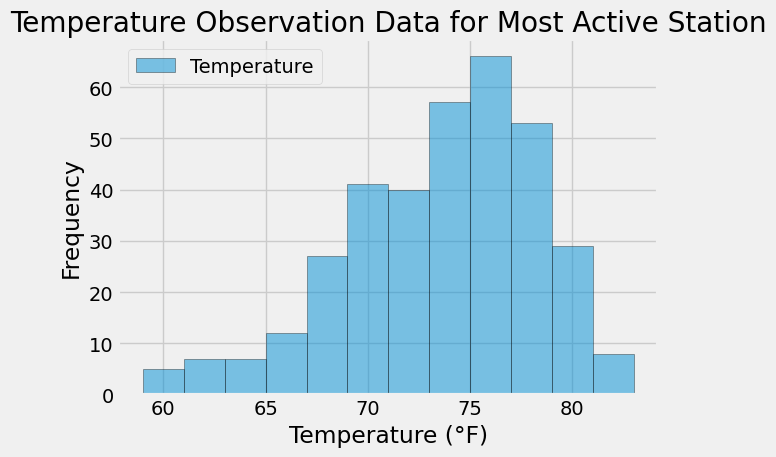

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = active_stations[0][0]

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = pd.to_datetime(last_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert back to string format

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago_str).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

temperature_df.plot.hist(bins=12, edgecolor='black', alpha=0.5)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Most Active Station')
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()